<a href="https://colab.research.google.com/github/siddhantkd/FY_HGS/blob/main/FY_UNET_SKD_OUHANDS_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

01 S Dutta Model OUHANDS

Retraining of S Dutta Model on OUHANDS 

NEXT STEPS 

> 01 S Dutta Model on Libras 

> 01 S Dutta Model with Parameter changes - Batch Size ( 16/32 )

#IMPORT AND DRIVE LOAD

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [ ]:
!nvidia-smi

Fri Dec 17 05:19:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


#Data Loading

In [ ]:
!unzip '/content/drive/MyDrive/OUHANDS/OUHANDS_Siddhant.zip'

In [ ]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

In [ ]:
path = "/content/OUHANDS_Siddhant/training/colour"
maskpath = "/content/OUHANDS_Siddhant/training/segmentation"

X_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating input data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_train[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_train[m]=mpg/255
    m+=1

creating input data


100%|██████████| 2000/2000 [00:06<00:00, 317.95it/s]


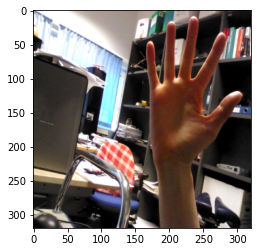

In [ ]:
plt.imshow(array_to_img(X_train[0]))

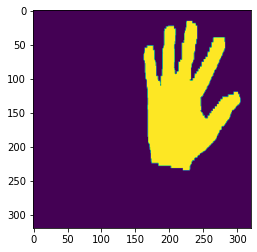

In [ ]:
plt.imshow(array_to_img(Y_train[0]))

# UNET MODEL

In [ ]:
X_train.shape

(2000, 320, 320, 3)

In [ ]:
def UNETmod():
  #Build the model
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

  #Contraction path

  c1 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(s)
  c1 = tf.keras.layers.BatchNormalization()(c1)
  c1 = tf.keras.layers.ReLU()(c1)
  c1 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
  c1 = tf.keras.layers.BatchNormalization()(c1)
  c1 = tf.keras.layers.ReLU()(c1)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
  c1 = tf.keras.layers.BatchNormalization()(c1)
  c1 = tf.keras.layers.ReLU()(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.BatchNormalization()(c2)
  c2 = tf.keras.layers.ReLU()(c2)
  c2 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c2)
  c2 = tf.keras.layers.BatchNormalization()(c2)
  c2 = tf.keras.layers.ReLU()(c2)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c2)
  c2 = tf.keras.layers.BatchNormalization()(c2)
  c2 = tf.keras.layers.ReLU()(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

  c3 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.BatchNormalization()(c3)
  c3 = tf.keras.layers.ReLU()(c3)
  c3 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
  c3 = tf.keras.layers.BatchNormalization()(c3)
  c3 = tf.keras.layers.ReLU()(c3)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
  c3 = tf.keras.layers.BatchNormalization()(c3)
  c3 = tf.keras.layers.ReLU()(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

  c4 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.BatchNormalization()(c4)
  c4 = tf.keras.layers.ReLU()(c4)
  c4 = tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(c4)
  c4 = tf.keras.layers.BatchNormalization()(c4)
  c4 = tf.keras.layers.ReLU()(c4)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c4)
  c4 = tf.keras.layers.BatchNormalization()(c4)
  c4 = tf.keras.layers.ReLU()(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.BatchNormalization()(c5)
  c5 = tf.keras.layers.ReLU()(c5)
  c5 = tf.keras.layers.Conv2D(512, (3, 3), kernel_initializer='he_normal', padding='same')(c5)
  c5 = tf.keras.layers.BatchNormalization()(c5)
  c5 = tf.keras.layers.ReLU()(c5)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(c5)
  c5 = tf.keras.layers.BatchNormalization()(c5)
  c5 = tf.keras.layers.ReLU()(c5)

  #Expansive path 
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.BatchNormalization()(c6)
  c6 = tf.keras.layers.ReLU()(c6)
  c6 = tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(c6)
  c6 = tf.keras.layers.BatchNormalization()(c6)
  c6 = tf.keras.layers.ReLU()(c6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c6)
  c6 = tf.keras.layers.BatchNormalization()(c6)
  c6 = tf.keras.layers.ReLU()(c6)
  
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.BatchNormalization()(c7)
  c7 = tf.keras.layers.ReLU()(c7)
  c7 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c7)
  c7 = tf.keras.layers.BatchNormalization()(c7)
  c7 = tf.keras.layers.ReLU()(c7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c7)
  c7 = tf.keras.layers.BatchNormalization()(c7)
  c7 = tf.keras.layers.ReLU()(c7)
  
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.BatchNormalization()(c8)
  c8 = tf.keras.layers.ReLU()(c8)
  c8 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c8)
  c8 = tf.keras.layers.BatchNormalization()(c8)
  c8 = tf.keras.layers.ReLU()(c8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c8)
  c8 = tf.keras.layers.BatchNormalization()(c8)
  c8 = tf.keras.layers.ReLU()(c8)
  
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.BatchNormalization()(c9)
  c9 = tf.keras.layers.ReLU()(c9)
  c9 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c9)
  c9 = tf.keras.layers.BatchNormalization()(c9)
  c9 = tf.keras.layers.ReLU()(c9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c9)
  c9 = tf.keras.layers.BatchNormalization()(c9)
  c9 = tf.keras.layers.ReLU()(c9)
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
  
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  return model


In [ ]:
model=UNETmod()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 320, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 320, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
#Our CNN model
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# MODEL TRAINING

##20 epochs

In [ ]:
#Model Checkpoint
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/SD_UNET_OUHANDS_01/cp.ckpt"
model_checkpoint_segmentUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentUNET,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [ ]:
history = model.fit(X_train,Y_train,validation_split = 0.1,batch_size=8,epochs=20,callbacks=[model_checkpoint_segmentUNET])

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.9511
Epoch 00001: val_accuracy improved from -inf to 0.84824, saving model to /content/drive/MyDrive/FY_HGS/SD_UNET_OUHANDS_01/cp.ckpt
225/225 [==============================] - 162s 647ms/step - loss: 0.2044 - accuracy: 0.9511 - val_loss: 1.0350 - val_accuracy: 0.8482
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.0794 - accuracy: 0.9757
Epoch 00002: val_accuracy improved from 0.84824 to 0.96395, saving model to /content/drive/MyDrive/FY_HGS/SD_UNET_OUHANDS_01/cp.ckpt
225/225 [==============================] - 144s 642ms/step - loss: 0.0794 - accuracy: 0.9757 - val_loss: 0.1115 - val_accuracy: 0.9639
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9795
Epoch 00003: val_accuracy improved from 0.96395 to 0.97497, saving model to /content/drive/MyDrive/FY_HGS/SD_UNET_OUHANDS_01/cp.ckpt
225/225 [==============================] - 144

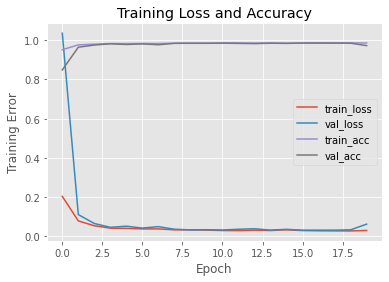

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 20
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), history.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), history.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

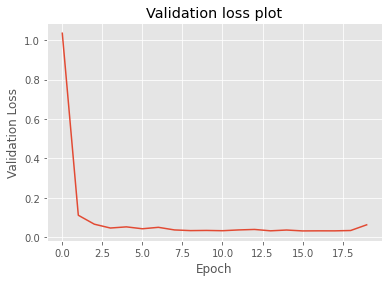

In [ ]:
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('UNET_ValLossPlot_SEGMENTATION_V1.2.png')

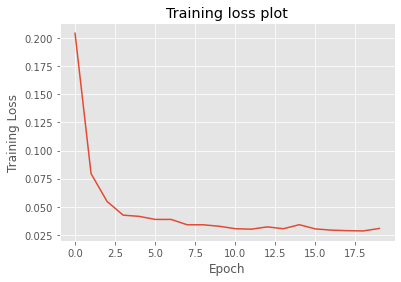

In [ ]:
plt.plot(np.arange(0,N), history.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

##40 Epochs

In [ ]:
checkpoint_path_segmentUNET = ""
model.load_weights(checkpoint_path_segmentUNET)

In [ ]:
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/SD_UNET_OUHANDS_01/40ep/cp.ckpt"
model_checkpoint_segmentUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentUNET,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [ ]:
h2 = model.fit(X_train,Y_train,validation_split = 0.1,batch_size=8,epochs=20,callbacks=[model_checkpoint_segmentUNET])

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9854
Epoch 00001: val_accuracy improved from -inf to 0.98527, saving model to /content/drive/MyDrive/FY_HGS/SD_UNET_OUHANDS_01/40ep/cp.ckpt
225/225 [==============================] - 146s 647ms/step - loss: 0.0301 - accuracy: 0.9854 - val_loss: 0.0311 - val_accuracy: 0.9853
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9863
Epoch 00002: val_accuracy did not improve from 0.98527
225/225 [==============================] - 145s 644ms/step - loss: 0.0277 - accuracy: 0.9863 - val_loss: 0.0302 - val_accuracy: 0.9852
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9864
Epoch 00003: val_accuracy did not improve from 0.98527
225/225 [==============================] - 144s 640ms/step - loss: 0.0275 - accuracy: 0.9864 - val_loss: 0.0356 - val_accuracy: 0.9837
Epoch 4/20
225/225 [==============================] - ETA: 0s 

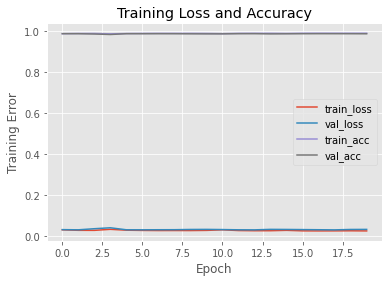

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 20
plt.plot(np.arange(0,N), h2.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h2.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h2.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), h2.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

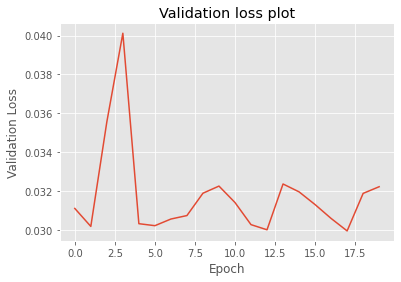

In [ ]:
plt.plot(np.arange(0,N), h2.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('UNET_ValLossPlot_SEGMENTATION_V1.2.png')

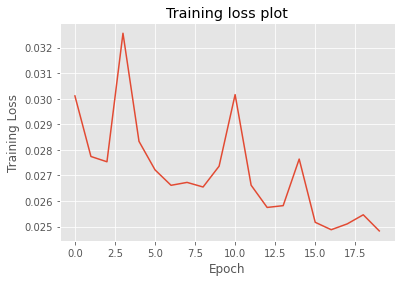

In [ ]:
plt.plot(np.arange(0,N), h2.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

# **EVALUATION**

In [ ]:
path = "/content/OUHANDS_Siddhant/testing/colour"
maskpath = "/content/OUHANDS_Siddhant/testing/segmentation"
p1 = os.listdir(path)
p1.sort()

m1 = os.listdir(maskpath)
m1.sort()

X_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating test data')
n=0
for name in tqdm(p1):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_test[n]=img
    n+=1

m=0
for name in tqdm(m1):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_test[m]=mpg/255
    m+=1

creating test data


100%|██████████| 1000/1000 [00:01<00:00, 529.06it/s]


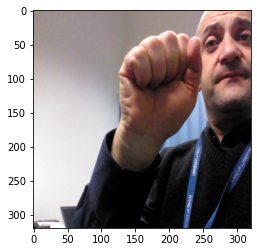

In [ ]:
plt.imshow(X_test[0])

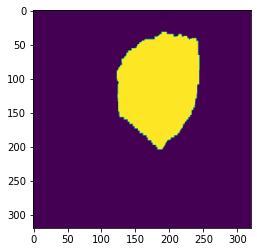

In [ ]:
plt.imshow(array_to_img(Y_test[0]))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import f1_score

In [ ]:
def fscore(tp,Images,Masks):
    total=0
    i=0
    fs=0
    for i in range(len(Images)):
        total += 1
        
        tp[i][tp[i]>0.5]=1
        tp[i][tp[i]<0.5]=0

        pred = img_to_array(tp[i]).astype(int)
        label = img_to_array(np.squeeze(Masks[i], axis=2)).astype(int)
        flat_pred = np.ravel(pred)
        flat_label = np.ravel(label)

        fs += f1_score(flat_label,flat_pred, average='micro')

    fs=fs/total

    return fs  

#20 epochs

In [ ]:
 #    ######evaluate#####
checkpoint_path_segmentUNET = "/content/drive/MyDrive/UNET/V1/SEGMENTATION/20Epochs/cp.ckpt"
model.load_weights(checkpoint_path_segmentUNET)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9523831738281249


In [ ]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.6868150559446907


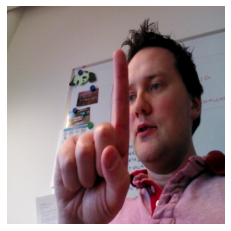

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test[270]))
#plt.title('TEST IMAGE')

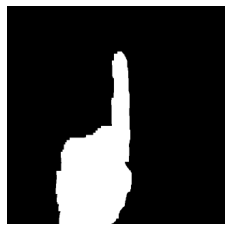

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(Y_test[270]), cmap = 'gray')
#plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

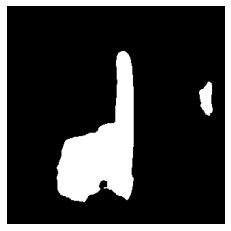

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred[273]), cmap = 'gray')
#plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

In [ ]:
x_test_single = np.expand_dims(X_test[10], axis = 0)

In [ ]:
import time
start_time = time.time()
y_single = model.predict(x_test_single)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.8144223690032959 seconds ---


## CUSTOM 20 ep


In [ ]:
!unzip '/content/drive/MyDrive/IMG_PNG.zip'

Archive:  /content/drive/MyDrive/IMG_PNG.zip
   creating: IMG_PNG/
  inflating: IMG_PNG/IMG_0332.png    
  inflating: IMG_PNG/IMG_0333.png    
  inflating: IMG_PNG/IMG_0334.png    
  inflating: IMG_PNG/IMG_0335.png    


In [ ]:
path = "/content/IMG_PNG"
p1 = os.listdir(path)

X_test_custom = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
print('creating test data')
n=0
for name in tqdm(p1):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_test_custom[n]=img
    n+=1

creating test data


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


In [ ]:
y_pred_custom=model.predict(X_test_custom)

Text(0.5, 1.0, 'TEST IMAGE')

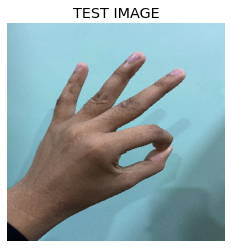

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test_custom[0]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

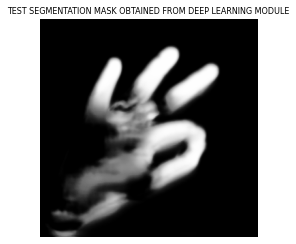

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred_custom[0]), cmap = 'gray')
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

Text(0.5, 1.0, 'TEST IMAGE')

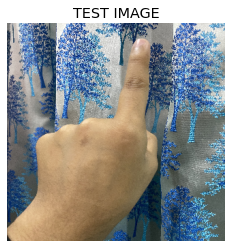

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test_custom[1]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

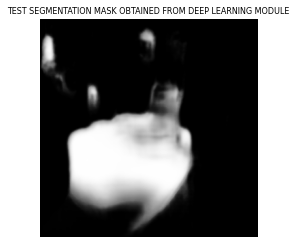

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred_custom[1]), cmap = 'gray')
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

Text(0.5, 1.0, 'TEST IMAGE')

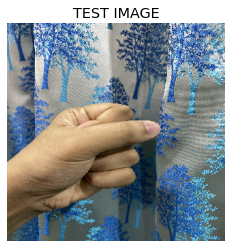

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test_custom[2]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

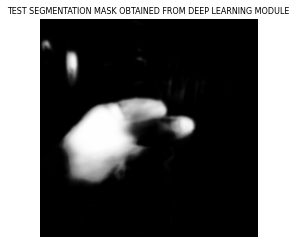

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred_custom[2]), cmap = 'gray')
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

Text(0.5, 1.0, 'TEST IMAGE')

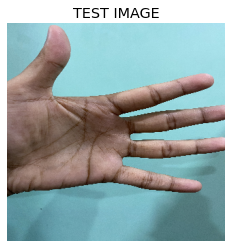

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test_custom[3]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

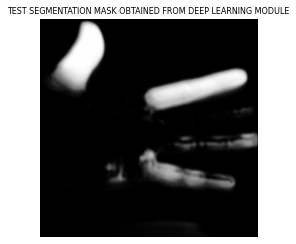

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred_custom[3]), cmap = 'gray')
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

#40Epochs

In [ ]:
 #    ######evaluate#####
checkpoint_path_segmentUNET = ""
model.load_weights(checkpoint_path_segmentUNET)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
f=fscore(y_pred,X_test,Y_test)
print(f)

0.960910859375


In [ ]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.726285815651112


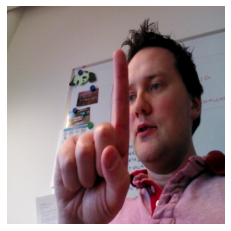

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test[270]))
#plt.title('TEST IMAGE')

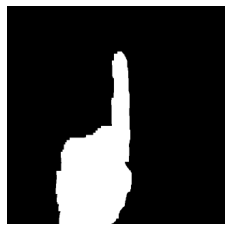

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(Y_test[270]), cmap = 'gray')
#plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

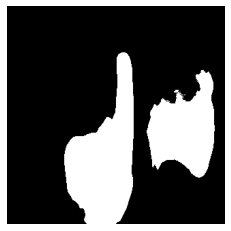

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred[273]), cmap = 'gray')
#plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

In [ ]:
import time
x_test_single = np.expand_dims(X_test[8], axis = 0)

start_time = time.time()
y_single = model.predict(x_test_single)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.08934760093688965 seconds ---


### Custom

In [ ]:
y_pred_custom=model.predict(X_test_custom)

Text(0.5, 1.0, 'TEST IMAGE')

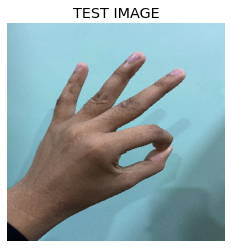

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test_custom[0]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

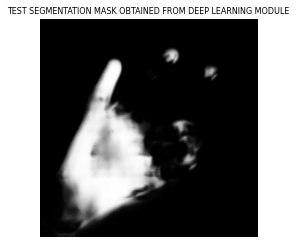

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred_custom[0]), cmap = 'gray')
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

Text(0.5, 1.0, 'TEST IMAGE')

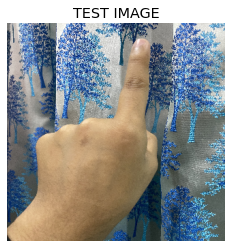

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test_custom[1]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

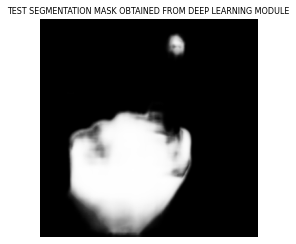

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred_custom[1]), cmap = 'gray')
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

Text(0.5, 1.0, 'TEST IMAGE')

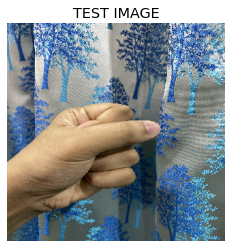

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test_custom[2]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

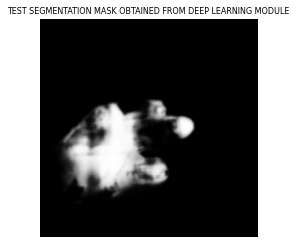

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred_custom[2]), cmap = 'gray')
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

Text(0.5, 1.0, 'TEST IMAGE')

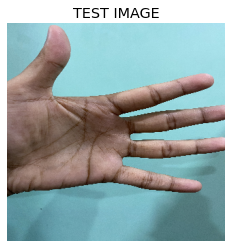

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test_custom[3]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

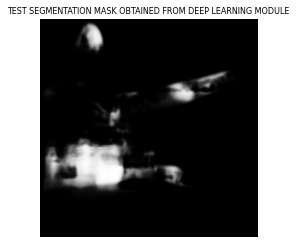

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred_custom[3]), cmap = 'gray')
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

#SAVE THE MODEL

In [ ]:
model.save("")